### Data Balancing

In [123]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import scipy as sp
from io import StringIO
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.metrics import decision_function
from sklearn.metrics import roc_curve

In [191]:
data_x = pd.read_csv('tornado-xtrain.csv')

In [222]:
data_y = pd.read_csv('tornado-ytrain.csv',header=None).drop(0,axis = 1)[1]

In [223]:
X = preprocessing.scale(data_x)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [224]:
Y = data_y

In [234]:
#### Use Stratify = Y

# How stratify works This stratify parameter makes a split
# so that the proportion of values in the sample produced 
# will be the same as the proportion of values provided to parameter stratify.
# For example, if variable y is a binary categorical variable with values 0 and 1
# and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split
# has 25% of 0's and 75% of 1's.

# apply SMOTE only to training set, test set does not have to be balanced
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
sm = SMOTE(sampling_strategy = 'not majority')

In [235]:
x_train_balanced, y_train_balanced = sm.fit_resample(x_train, y_train)

In [236]:
len(y_test[y_test == 0])

2162

In [237]:
len(y_test[y_test == 1])

159

In [238]:
len(y_test[y_test == 2])

21

In [242]:
len(y_train_balanced[y_train_balanced == 0])

8643

In [243]:
len(y_train_balanced[y_train_balanced == 1])

8643

In [244]:
len(y_train_balanced[y_train_balanced == 2])

8643

### Decision Tree MultiClass Classifier

### Decision Tree Hyperparameter Tuning

### Default Parameters

In [245]:
default_parameters = DecisionTreeClassifier().fit(x_train_balanced, y_train_balanced)
y_pred = default_parameters.predict(x_test)

Confusion Matrix

In [247]:
array = confusion_matrix(y_test, y_pred)

In [248]:
[array[i]/sum(array[i]) for i in range(len(array))]

[array([0.90471785, 0.0892692 , 0.00601295]),
 array([0.53459119, 0.35849057, 0.10691824]),
 array([0.14285714, 0.57142857, 0.28571429])]

F1 Score

In [246]:
f1_score(y_test, y_pred, average = 'macro')

0.4704700070390397

In [351]:
dict(zip(default_parameters.feature_importances_,data_x.columns))

{0.043739556976312946: 'EVENT_ID',
 0.030163967488719433: 'median_income',
 0.04217026144454209: 'population_density',
 0.052976310148100704: 'housing_units_density',
 0.11855521505040814: 'duration',
 0.01420138240936251: 'weekend',
 0.03911391012097358: 'sin_time',
 0.04566452180552874: 'cos_time',
 0.07010079456157331: 'sin_date',
 0.03298655521382658: 'cos_date',
 0.18404225002299593: 'tornado_intensity',
 0.13252139132067745: 'tornado_area',
 0.04013709199523866: 'average_range',
 0.048566038869812714: 'minimum_range',
 0.039951245971185365: 'average_latitude',
 0.03253964329930844: 'average_longitude',
 0.02982518026936688: 'percent_land',
 0.002744683032066454: 'multi_vortex'}

### Tuning split and leaf without cross-validation

In [264]:
min_samples_split_values = list(range(2,200,20))
min_samples_leaf_values = list(range(1,60,6))

In [265]:
plotting_data = []
for i in min_samples_split_values:
    for j in min_samples_leaf_values:
        dt = DecisionTreeClassifier(min_samples_split = i,min_samples_leaf=j).fit(x_train_balanced, y_train_balanced)
        y_pred = dt.predict(x_test)
        row = [i ,j, f1_score(y_test, y_pred, average = 'macro')]
        plotting_data.append(row)

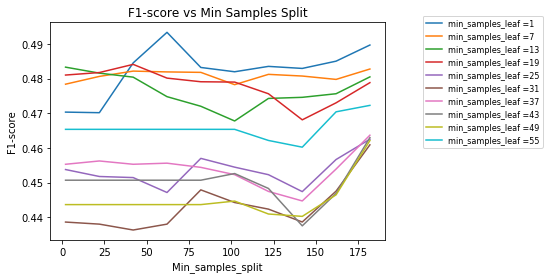

<Figure size 1080x576 with 0 Axes>

In [266]:
plotting = pd.DataFrame(plotting_data)
for i in min_samples_leaf_values:
    plt.plot(plotting[0][plotting[1] == i], plotting[2][plotting[1] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

In [267]:
plotting = plotting.rename(columns={ 0: 'Min_Samples_Split', 1: 'Min_Samples_Leaf', 2: 'f1_score'})

In [268]:
#fluctuating between 62 and 182
plotting[plotting['f1_score'] == plotting['f1_score'].max()]

,Min_Samples_Split,Min_Samples_Leaf,f1_score
30,62,1,0.493323


### Most important features are tornado_intensity', 'tornado_area' and  'minimum_range', followed by 'duration'.

### Tuning split and leaf with cross-validation

In [333]:
k = 5
plotting_data2 = []
kf = KFold(n_splits=k)    
for train_index, test_index in kf.split(x_train_balanced):
    X_cv_train, X_cv_validate = pd.DataFrame(x_train_balanced).iloc[train_index], pd.DataFrame(x_train_balanced).iloc[test_index]
    Y_cv_train, Y_cv_validate = pd.DataFrame(y_train_balanced).iloc[train_index], pd.DataFrame(y_train_balanced).iloc[test_index]
    for i in min_samples_split_values:
        for j in min_samples_leaf_values:
            dt = DecisionTreeClassifier(min_samples_split = i, min_samples_leaf=j).fit(X_cv_train, Y_cv_train)
            y_pred = dt.predict(X_cv_validate)
            row = [i ,j, f1_score(Y_cv_validate, y_pred, average = 'macro')]
            plotting_data2.append(row)            

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

In [334]:
plotting2 = pd.DataFrame(plotting_data2)

In [335]:
plotting2 = plotting2.rename(columns={ 0: 'Min_Samples_Split', 1: 'Min_Samples_Leaf', 2: 'f1_score'})

In [336]:
plotting2[plotting2['f1_score'] == plotting2['f1_score'].max()]

,Min_Samples_Split,Min_Samples_Leaf,f1_score
100,2,1,0.791516


### Average Values from Cross-Validation

In [273]:
average_values = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).mean().reset_index()

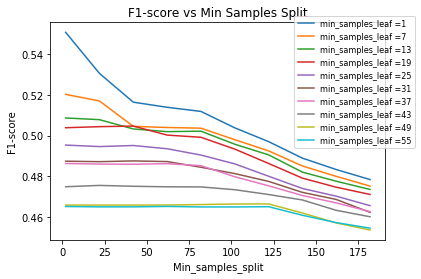

<Figure size 1080x576 with 0 Axes>

In [274]:
for i in min_samples_leaf_values:
    plt.plot(average_values['Min_Samples_Split'][average_values['Min_Samples_Leaf'] == i], average_values['f1_score'][average_values['Min_Samples_Leaf'] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

### Plus 2 Standard Deviation from Cross-Validation

In [275]:
std_deviation = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).std().reset_index()

In [276]:
plus2std = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).std().reset_index()

In [277]:
plus2std['f1_score'] = average_values['f1_score'] + 2*std_deviation['f1_score']

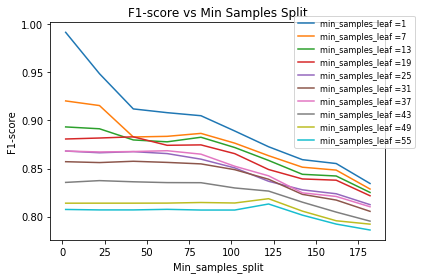

<Figure size 1080x576 with 0 Axes>

In [278]:
for i in min_samples_leaf_values:
    plt.plot(plus2std['Min_Samples_Split'][plus2std['Min_Samples_Leaf'] == i], plus2std['f1_score'][plus2std['Min_Samples_Leaf'] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

### Minus 2 Standard Deviation from Cross-Validation

In [279]:
minus2std = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).std().reset_index()

In [280]:
minus2std['f1_score'] = average_values['f1_score'] - 2*std_deviation['f1_score']

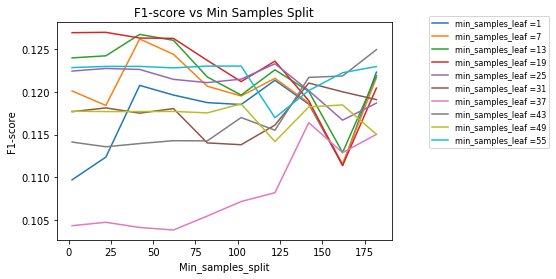

<Figure size 1080x576 with 0 Axes>

In [281]:
for i in min_samples_leaf_values:
    plt.plot(minus2std['Min_Samples_Split'][minus2std['Min_Samples_Leaf'] == i], minus2std['f1_score'][minus2std['Min_Samples_Leaf'] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

### Best hyperparameters: min_samples_split = 2,min_samples_leaf=1

In [294]:
dt2 = DecisionTreeClassifier(min_samples_split = 2,min_samples_leaf=1).fit(x_train_balanced, y_train_balanced)
y_pred = dt2.predict(x_test)
f1_score(y_test, y_pred, average = 'macro')

0.47152525449786303

In [285]:
dt2.feature_importances_

array([0.02900387, 0.03216046, 0.05629043, 0.03189275, 0.0446217 ,
       0.00819678, 0.03760829, 0.03731743, 0.04159794, 0.03494814,
       0.28494104, 0.16977121, 0.03102318, 0.08818427, 0.0251745 ,
       0.02712401, 0.01897234, 0.00117164])

### Random Forest Classifier

### Default Parameters

In [295]:
default_parameters_rf = RandomForestClassifier().fit(x_train_balanced, y_train_balanced)
y_pred = default_parameters_rf.predict(x_test)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion Matrix

In [296]:
array = confusion_matrix(y_test, y_pred)

In [297]:
[array[i]/sum(array[i]) for i in range(len(array))]

[array([0.95235893, 0.0453284 , 0.00231267]),
 array([0.53459119, 0.44025157, 0.02515723]),
 array([0.14285714, 0.76190476, 0.0952381 ])]

F1 Score

In [299]:
f1_score(y_test, y_pred, average = 'macro')

0.4962791452157564

### Tuning on n_estimators and max_depth

In [308]:
estimators = [10,100,500,1000]
maxdepth = [None,20,40,60,80]

In [309]:
plotting_data = []
for i in estimators:
    for j in maxdepth:
        dt = RandomForestClassifier(n_estimators = i, max_depth = j).fit(x_train_balanced, y_train_balanced)
        y_pred = dt.predict(x_test)
        row = [i ,j, f1_score(y_test, y_pred, average = 'macro')]
        plotting_data.append(row)

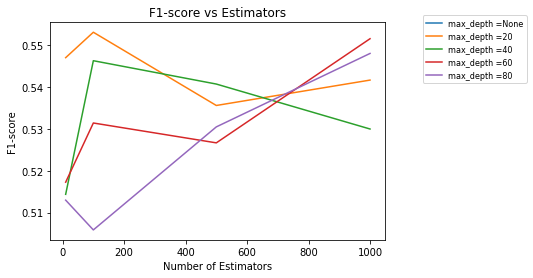

<Figure size 1080x576 with 0 Axes>

In [325]:
plotting = pd.DataFrame(plotting_data)
for i in maxdepth:
    plt.plot(plotting[0][plotting[1] == i], plotting[2][plotting[1] == i], label = "max_depth =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Estimators")
plt.ylabel("F1-score")
plt.xlabel("Number of Estimators")
plt.figure(figsize=(15,8))
plt.show()

In [320]:
plotting[plotting[2] == plotting[2].max()]

,0,1,2
6,100,20.0,0.553007


### Best parameters -  n_estimators = 100, max_depth = 20

In [337]:
rfclf = RandomForestClassifier(n_estimators = 100, max_depth = 20).fit(x_train_balanced, y_train_balanced)
y_pred = rfclf.predict(x_test)


In [338]:
f1_score(y_test, y_pred, average = 'macro')

0.5425634027194103

In [339]:
array = confusion_matrix(y_test, y_pred)

In [340]:
array

array([[2040,  118,    4],
       [  78,   74,    7],
       [   1,   15,    5]])

In [345]:
array2 = [np.round(array[i]/sum(array[i])*100,0) for i in range(len(array))]

Text(0.5,1,'Random Forest Confusion Matrix Heatmap')

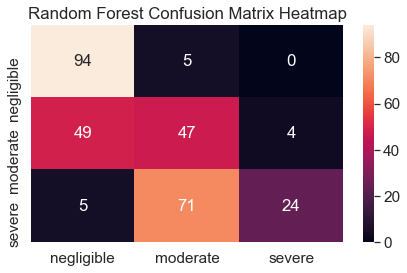

In [347]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array_to_plot = array2
df_cm = pd.DataFrame(array_to_plot, index = ['negligible','moderate','severe'], columns = ['negligible','moderate','severe'])
plt.figure(figsize = (7,4))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True)
plt.title("Random Forest Confusion Matrix Heatmap")